In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
def three_hump_camel(x,y) :
    return 2*x**2 - 1.05*x**4 + (x**6)/6 + x*y +y**2

def three_hump_camel_grad(x,y) :
    return np.array([4*x - 4.2*x**3 + x**5 + y, x + 2*y])

limits = (-5, 5)
optim = (0, 0)
init = (-3,-4)

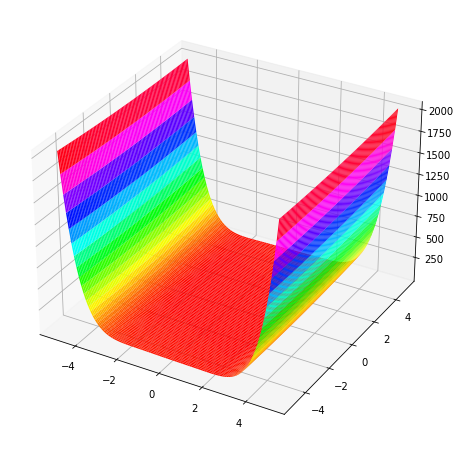

In [3]:
plt.figure(figsize=(8,8))
x = np.linspace(limits[0], limits[1], 100)
X, Y = np.meshgrid(x, x)
ax = plt.subplot(111, projection='3d')
ax.plot_surface(X, Y, three_hump_camel(X, Y), rstride=1, cstride=1, cmap='hsv')
plt.show()

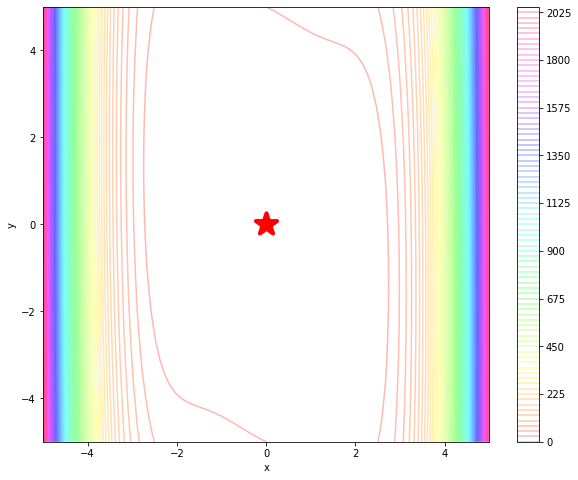

In [4]:
plt.figure(figsize=(10,8))
plt.contour(X, Y, three_hump_camel(X,Y), 100, alpha=.3, cmap='hsv')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(optim[0], optim[1], marker='*', s=500, color='red', linewidth=4);

In [8]:
def annealing(fun, init, n_iterations, t0 = 1.0, q=0.8, step_size=0.1):
    traj = [np.array(init)]
    t = t0
    for k in range(n_iterations):
        x = traj[-1]
        proposal = np.random.normal(loc=x, scale=step_size)
        log_alpha = (fun(x[0], x[1]) - fun(proposal[0], proposal[1]))/t
        if np.log(np.random.random()) < log_alpha:
            x = proposal
        traj.append(x)
        t *= q
    return np.array(traj).T

def gradientDescent(fun, grad_fun, init, n_iterations, eta):
    traj = [np.array(init)]
    for k in range(n_iterations):
        x = traj[-1]
        x = x - eta * grad_fun(x[0], x[1])
        traj.append(x)
    return np.array(traj).T

def momentum(fun, grad_fun, init, n_iterations, beta, eta):
    traj = [np.array(init)]
    v = 0
    for k in range(n_iterations):
        x = traj[-1]
        grad = grad_fun(x[0], x[1])
        v = beta * v - eta * grad
        x = x + v
        traj.append(x)
    return np.array(traj).T

def nesterovMomentum(fun, grad_fun, init, n_iterations, beta, eta):
    traj = [np.array(init)]
    v = 0
    for k in range(n_iterations):
        x = traj[-1]
        grad = grad_fun((x + beta * v)[0], (x + beta * v)[1])
        v = beta * v - eta * grad
        x = x + v
        traj.append(x)
    return np.array(traj).T

def adagrad(fun, grad_fun, init, n_iterations, eta, eps=1e-7):
    traj = [np.array(init)]
    s = 0
    for k in range(n_iterations):
        x = traj[-1]
        grad = grad_fun(x[0], x[1])
        s += grad**2
        x = x - eta / np.sqrt(s + eps) * grad_fun(x[0], x[1])
        traj.append(x)
    return np.array(traj).T

def RMSProp(fun, grad_fun, init, n_iterations, eta, rho, eps=1e-7):
    traj = [np.array(init)]
    s = 0
    for k in range(n_iterations):
        x = traj[-1]
        grad = grad_fun(x[0], x[1])
        s = rho * s + (1-rho)* grad**2
        x = x - eta / np.sqrt(s + eps) * grad_fun(x[0], x[1])
        traj.append(x)
    return np.array(traj).T

def adadelta(fun, grad_fun, init, n_iterations, rho, eps=1e-3):
    traj = [np.array(init)]
    s = 0
    d = 0
    for k in range(n_iterations):
        x = traj[-1]
        grad = grad_fun(x[0], x[1])
        s = rho * s + (1-rho) * grad**2
        x = x - np.sqrt(d + eps) / np.sqrt(s + eps) * grad_fun(x[0], x[1])
        traj.append(x)
        d = rho * d + (1-rho) * (traj[-1]-traj[-2])**2
    return np.array(traj).T

def adam(fun, grad_fun, init, n_iterations, beta_1, beta_2, eta, eps=1e-8):
    traj = [np.array(init)]
    v = 0
    s = 0
    for k in range(n_iterations):
        x = traj[-1]
        grad = grad_fun(x[0], x[1])
        v = beta_1 * v + (1-beta_1) * grad
        s = beta_2 * s + (1-beta_2) * grad**2
        vhat = v / (1-beta_1**(k+1))
        shat = s / (1-beta_2**(k+1))
        x = x - eta / np.sqrt(shat + eps) * vhat
        traj.append(x)
    return np.array(traj).T

tol = 0.1
def n_steps(traj) :
    max_0 = np.max(np.where(abs(traj)[0] > tol)) + 1
    max_1 = np.max(np.where(abs(traj)[1] > tol)) + 1
    return max(max_0,max_1)

In [9]:
dic = {'params':[],'reached_opt':[],'n_steps':[]}

for t0 in np.logspace(-3,2,6) :
    for q in np.arange(0.1,1,0.1) :
        for step_size in np.logspace(-5,-1,5) :
            traj = annealing(three_hump_camel, init, 200, t0=t0, q=q, step_size=step_size)
            dic['params'].append(f'{t0=}, {q=}, {step_size=}')
            dic['reached_opt'].append(np.all(abs(traj[:,-1]) < tol))
            dic['n_steps'].append(n_steps(traj))

print('Annealing')
pd.DataFrame(dic).sort_values('n_steps').reset_index(drop=True).loc[:5,:]
# Оптимальны разные комбинации параметров, так как есть фактор случайности

Annealing


,params,reached_opt,n_steps
0,"t0=100.0, q=0.1, step_size=0.1",True,110
1,"t0=0.001, q=0.6, step_size=0.1",True,112
2,"t0=10.0, q=0.30000000000000004, step_size=0.1",True,115
3,"t0=1.0, q=0.2, step_size=0.1",True,117
4,"t0=0.1, q=0.5, step_size=0.1",True,117
5,"t0=0.01, q=0.5, step_size=0.1",True,117


In [10]:
dic = {'params':[],'reached_opt':[],'n_steps':[]}

for eta in np.logspace(-5,-2,4) :
    traj = gradientDescent(three_hump_camel, three_hump_camel_grad, init, n_iterations=200, eta=eta)
    dic['params'].append(f'{eta=}')
    dic['reached_opt'].append(np.all(abs(traj[:,-1]) < tol))
    dic['n_steps'].append(n_steps(traj))

print('Gradient Descent')
pd.DataFrame(dic).sort_values('n_steps').reset_index(drop=True)

Gradient Descent


,params,reached_opt,n_steps
0,eta=0.01,True,197
1,eta=1e-05,False,201
2,eta=0.0001,False,201
3,eta=0.001,False,201


In [11]:
dic = {'params':[],'reached_opt':[],'n_steps':[]}

for eta in np.logspace(-5,-2,4) :
    for beta in np.arange(0.1,1,0.1) :
        traj = momentum(three_hump_camel, three_hump_camel_grad, init, n_iterations=200, beta=beta, eta=eta)
        dic['params'].append(f'{eta=}, {beta=}')
        dic['reached_opt'].append(np.all(abs(traj[:,-1]) < tol))
        dic['n_steps'].append(n_steps(traj))
        
print('Momentum')
pd.DataFrame(dic).sort_values('n_steps').reset_index(drop=True).loc[:5,:]

Momentum


,params,reached_opt,n_steps
0,"eta=0.01, beta=0.8",True,32
1,"eta=0.01, beta=0.9",True,76
2,"eta=0.01, beta=0.5",True,112
3,"eta=0.01, beta=0.4",True,129
4,"eta=0.01, beta=0.30000000000000004",True,148
5,"eta=0.01, beta=0.2",True,167


In [12]:
dic = {'params':[],'reached_opt':[],'n_steps':[]}

for eta in np.logspace(-5,-2,4) :
    for beta in np.arange(0.1,1,0.1) :
        traj = nesterovMomentum(three_hump_camel, three_hump_camel_grad, init, n_iterations=200, beta=beta, eta=eta)
        dic['params'].append(f'{eta=}, {beta=}')
        dic['reached_opt'].append(np.all(abs(traj[:,-1]) < tol))
        dic['n_steps'].append(n_steps(traj))
        
print('Nesterov Momentum')
pd.DataFrame(dic).sort_values('n_steps').reset_index(drop=True).loc[:5,:]

Nesterov Momentum


,params,reached_opt,n_steps
0,"eta=0.01, beta=0.9",True,62
1,"eta=0.01, beta=0.5",True,114
2,"eta=0.01, beta=0.4",True,131
3,"eta=0.01, beta=0.30000000000000004",True,150
4,"eta=0.01, beta=0.2",True,168
5,"eta=0.01, beta=0.1",True,183


In [13]:
dic = {'params':[],'reached_opt':[],'dist_to_opt':[]}

for eta in np.logspace(-6,0,7) :
    traj = adagrad(three_hump_camel, three_hump_camel_grad, init, n_iterations=200, eta=eta, eps=1e-7)
    dic['params'].append(f'{eta=}')
    dic['reached_opt'].append(np.all(abs(traj[:,-1]) < tol))
    dic['dist_to_opt'].append(np.linalg.norm(traj[:,-1]))
    
print('Adagrad')
pd.DataFrame(dic).sort_values('dist_to_opt').reset_index(drop=True).loc[:5,:]
# Ни один набор гиперпараметров не позволил достигнуть оптимума, берем параметры, которые довели ближе всего

Adagrad


,params,reached_opt,dist_to_opt
0,eta=1.0,False,1.953823
1,eta=0.1,False,2.496303
2,eta=0.01,False,4.642200
3,eta=0.001,False,4.962586
4,eta=0.0001,False,4.996242
5,eta=1e-05,False,4.999624


In [14]:
dic = {'params':[],'reached_opt':[],'n_steps':[]}

for eta in np.logspace(-5,-1,5) :
    for rho in np.arange(0.1,1,0.1) :
        traj = RMSProp(three_hump_camel, three_hump_camel_grad, init, n_iterations=200, eta=eta, rho=rho, eps=1e-7)
        dic['params'].append(f'{eta=}, {rho=}')
        dic['reached_opt'].append(np.all(abs(traj[:,-1]) < tol))
        dic['n_steps'].append(n_steps(traj))
        
print('RMSProp')
pd.DataFrame(dic).sort_values('n_steps').reset_index(drop=True).loc[:5,:]

RMSProp


,params,reached_opt,n_steps
0,"eta=0.1, rho=0.1",True,40
1,"eta=0.1, rho=0.30000000000000004",True,41
2,"eta=0.1, rho=0.2",True,41
3,"eta=0.1, rho=0.4",True,43
4,"eta=0.1, rho=0.5",True,48
5,"eta=0.1, rho=0.6",True,55


In [15]:
dic = {'params':[],'reached_opt':[],'n_steps':[]}

for rho in np.arange(0.1,1,0.1) :
    traj = adadelta(three_hump_camel, three_hump_camel_grad, init, n_iterations=200, rho=rho, eps=1e-5)
    dic['params'].append(f'{rho=}')
    dic['reached_opt'].append(np.all(abs(traj[:,-1]) < tol))
    dic['n_steps'].append(n_steps(traj))
    
print('Adadelta')
pd.DataFrame(dic).sort_values('n_steps').reset_index(drop=True).loc[:5,:]

Adadelta


,params,reached_opt,n_steps
0,rho=0.1,True,164
1,rho=0.2,True,178
2,rho=0.30000000000000004,True,194
3,rho=0.4,False,201
4,rho=0.5,False,201
5,rho=0.6,False,201


In [16]:
dic = {'params':[],'reached_opt':[],'n_steps':[]}

for beta_1 in np.arange(0.1,1,0.1) :
    for beta_2 in np.arange(0.1,1,0.1) :
        for eta in np.logspace(-5,-1,5) :
            traj = adam(three_hump_camel, three_hump_camel_grad, init, n_iterations=200, beta_1=beta_1, beta_2=beta_2, eta=eta, eps=1e-8)
            dic['params'].append(f'{eta=}, {beta_1=}, {beta_2=}')
            dic['reached_opt'].append(np.all(abs(traj[:,-1]) < tol))
            dic['n_steps'].append(n_steps(traj))

print('Adam')
pd.DataFrame(dic).sort_values('n_steps').reset_index(drop=True).loc[:5,:]

Adam


,params,reached_opt,n_steps
0,"eta=0.1, beta_1=0.4, beta_2=0.2",True,38
1,"eta=0.1, beta_1=0.5, beta_2=0.30000000000000004",True,38
2,"eta=0.1, beta_1=0.30000000000000004, beta_2=0.1",True,38
3,"eta=0.1, beta_1=0.2, beta_2=0.1",True,39
4,"eta=0.1, beta_1=0.4, beta_2=0.30000000000000004",True,39
5,"eta=0.1, beta_1=0.5, beta_2=0.4",True,39


In [30]:
annealing_traj = annealing(three_hump_camel, init, 200, t0=1, q=0.6, step_size=0.1)
gradient_traj = gradientDescent(three_hump_camel, three_hump_camel_grad, init, n_iterations=200, eta=0.01)
momentum_traj = momentum(three_hump_camel, three_hump_camel_grad, init, n_iterations=200, beta=0.8, eta=0.01)
nesterov_momentum_traj = nesterovMomentum(three_hump_camel, three_hump_camel_grad, init, n_iterations=200, beta=0.9, eta=0.01)
adagrad_traj = adagrad(three_hump_camel, three_hump_camel_grad, init, n_iterations=200, eta=1.0, eps=1e-7)
rmsprop_traj = RMSProp(three_hump_camel, three_hump_camel_grad, init, n_iterations=200, eta=0.1, rho=0.1, eps=1e-7)
adadelta_traj = adadelta(three_hump_camel, three_hump_camel_grad, init, n_iterations=200, rho=0.1, eps=1e-5)
adam_traj = adam(three_hump_camel, three_hump_camel_grad, init, n_iterations=200, beta_1=0.4, beta_2=0.2, eta=0.1, eps=1e-8)

In [31]:
params = ['t0=1, q=0.6, step_size=0.1', 'eta=0.01', 'beta=0.8, eta=0.01', 'beta=0.9, eta=0.01', 'eta=1.0, eps=1e-7', 
          'eta=0.1, rho=0.1, eps=1e-7', 'rho=0.1, eps=1e-5', 'beta_1=0.4, beta_2=0.2, eta=0.1, eps=1e-8']
out_dict = {'Annealing':annealing_traj, 'Gradient Descent':gradient_traj, 'Momentum':momentum_traj, 
            'Nesterov Momentum':nesterov_momentum_traj, 'Adagrad':adagrad_traj, 'RMSProp':rmsprop_traj,
            'Adadelta':adadelta_traj, 'Adam':adam_traj}

In [32]:
out_df = pd.DataFrame({'Method':out_dict.keys(), 'Params':params, 'N steps':[n_steps(val) for val in out_dict.values()]}).sort_values('N steps').reset_index(drop=True)
out_df.loc[out_df['N steps'] > 200,'N steps'] = 'Opt not reached'

In [33]:
out_df

,Method,Params,N steps
0,Momentum,"beta=0.8, eta=0.01",32
1,Adam,"beta_1=0.4, beta_2=0.2, eta=0.1, eps=1e-8",38
2,RMSProp,"eta=0.1, rho=0.1, eps=1e-7",40
3,Nesterov Momentum,"beta=0.9, eta=0.01",62
4,Annealing,"t0=1, q=0.6, step_size=0.1",128
5,Adadelta,"rho=0.1, eps=1e-5",164
6,Gradient Descent,eta=0.01,197
7,Adagrad,"eta=1.0, eps=1e-7",Opt not reached


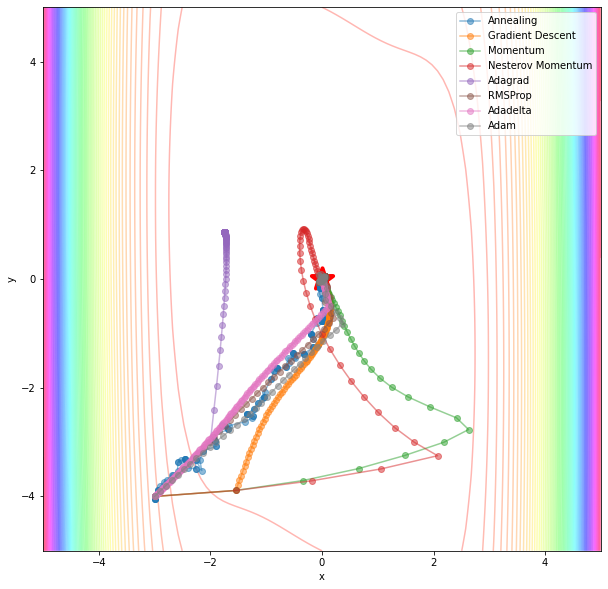

In [34]:
plt.figure(figsize=(10,10))
plt.contour(X, Y, three_hump_camel(X,Y), 100, alpha=.3, cmap='hsv')
plt.scatter(optim[0], optim[1], marker='*', s=500, color='red', linewidth=4)
plt.xlabel('x')
plt.ylabel('y')
for key, val in out_dict.items() :
    plt.plot(val[0], val[1], marker='o', alpha=.5,
            label=key)
plt.legend();